In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/envs/toxic35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
EMBEDDING_FILE = '../data/glove.6B.50d.txt'
TRAIN_DATA_FILE = '../data/train.csv'
TEST_DATA_FILE = '../data/test.csv'

In [3]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [4]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

# "standard keras preprocessing"

In [5]:
%%time
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

CPU times: user 27.9 s, sys: 240 ms, total: 28.2 s
Wall time: 28.2 s


In [6]:
%%time
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

CPU times: user 6.29 s, sys: 236 ms, total: 6.53 s
Wall time: 6.36 s


In [7]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940494, 0.64410406)

In [8]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
embedding_matrix

array([[-0.05729025, -0.09410239, -0.43545319, ..., -0.76319059,
         0.77463431,  0.17687941],
       [ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.68046999, -0.039263  ,  0.30186   , ..., -0.073297  ,
        -0.064699  , -0.26043999],
       ...,
       [-0.13491   , -0.8635    , -0.033898  , ...,  0.29484999,
        -0.24315999,  0.81682003],
       [ 0.1178    ,  0.14624   , -0.28240001, ..., -0.19529   ,
        -0.13610999,  1.04270005],
       [-0.64388001, -0.54152   ,  0.10305   , ..., -0.06732   ,
        -0.73308003,  0.88625002]])

In [9]:
from types import SimpleNamespace
def make_small(X_t, y, rows): 
    small = SimpleNamespace()
    small.choices = np.random.choice(X_t.shape[0], rows, replace=False)
    small.X_t = X_t[small.choices, :]
    small.y = y[small.choices, :]
    return small

# visualize

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
def show_me(model):
    return SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

# Model 1

In [11]:
%%time
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

CPU times: user 1.97 s, sys: 108 ms, total: 2.08 s
Wall time: 1.92 s


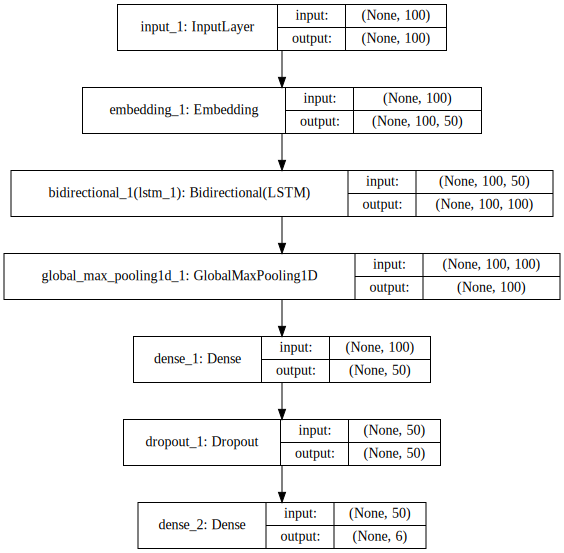

In [17]:
show_me(model)

In [13]:
small = make_small(X_t, y, 5000)
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=0,verbose=True,mode='auto')
model.fit(small.X_t, small.y,
          batch_size=32, 
          epochs=15, 
          validation_split=0.1, 
          verbose=True, 
          callbacks=[early_stopping])

Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 47s - loss: 0.1695 - acc: 0.9596 - val_loss: 0.1127 - val_acc: 0.9640
Epoch 2/15
4500/4500 [==============================] - 47s - loss: 0.0973 - acc: 0.9667 - val_loss: 0.0845 - val_acc: 0.9707
Epoch 3/15
4500/4500 [==============================] - 47s - loss: 0.0689 - acc: 0.9751 - val_loss: 0.0671 - val_acc: 0.9790
Epoch 4/15
4500/4500 [==============================] - 46s - loss: 0.0577 - acc: 0.9791 - val_loss: 0.0658 - val_acc: 0.9783
Epoch 5/15
4500/4500 [==============================] - 46s - loss: 0.0500 - acc: 0.9820 - val_loss: 0.0597 - val_acc: 0.9770
Epoch 6/15
4500/4500 [==============================] - 46s - loss: 0.0454 - acc: 0.9835 - val_loss: 0.0604 - val_acc: 0.9777
Epoch 00005: early stopping


# Model 2

In [14]:
%%time
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dense(50, activation="relu")(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model2 = Model(inputs=inp, outputs=x)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

CPU times: user 1.81 s, sys: 40 ms, total: 1.85 s
Wall time: 1.53 s


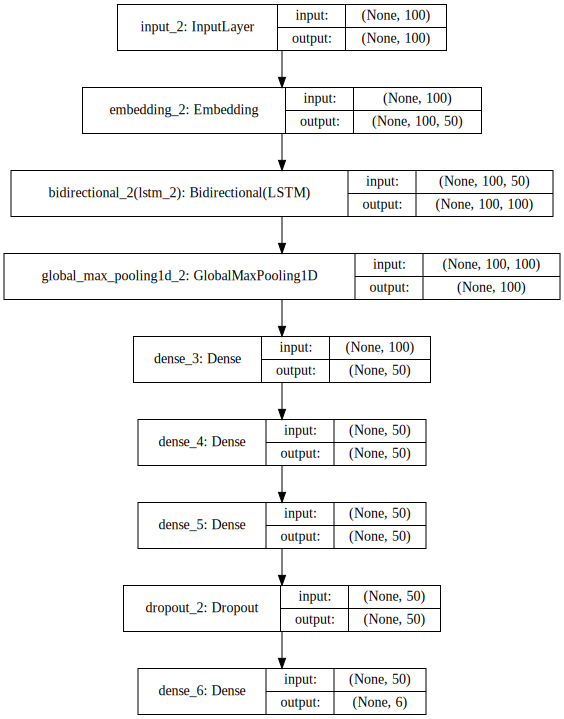

In [ ]:
show_me(model2)

In [ ]:
small = make_small(X_t, y, 5000)
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=True,
    mode='auto'
)
model2.fit(
    small.X_t, small.y,
    batch_size=32, 
    epochs=15, 
    validation_split=0.1, 
    verbose=True, 
    callbacks=[early_stopping])

Train on 4500 samples, validate on 500 samples
Epoch 1/15
4500/4500 [==============================] - 47s - loss: 0.1795 - acc: 0.9576 - val_loss: 0.0869 - val_acc: 0.9680
Epoch 2/15
4500/4500 [==============================] - 47s - loss: 0.0880 - acc: 0.9692 - val_loss: 0.0560 - val_acc: 0.9783
Epoch 3/15
4500/4500 [==============================] - 47s - loss: 0.0614 - acc: 0.9788 - val_loss: 0.0548 - val_acc: 0.9780
Epoch 4/15
4500/4500 [==============================] - 47s - loss: 0.0516 - acc: 0.9818 - val_loss: 0.0533 - val_acc: 0.9787
Epoch 5/15
2976/4500 [==================>...........] - ETA: 15s - loss: 0.0459 - acc: 0.9835